<a href="https://colab.research.google.com/github/Dr-Isam-ALJAWARNEH/ds-project-clustering-AQ-data/blob/main/DBSCAN_HDBSCAN_updated_April24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Date: 4 March 2024

<font color='blue'> Authors:</font>
- Manar Anwer
- Amna Salim
- Shruti Govonda
- [Dr. Isam Al Jawarneh](https://isamaljawarneh.github.io/) (```supervisor```)


##Target
analyzing fine-grained (i.e., granular) environmental data. In this notebook :

*   time series graphs
*   basic maps with environmental data (low-cost Air Quality, AQ, sensors data)
*   Perform clustering analysis (e.g., DBSCAN) on pollution hotspots


##Part 0: Setup

Here, we are going to call Python libraries - modules of code that allow us to have different types of functionality in our program.

In [ ]:
#Block 1
#here, we install the tool we are going to use to make some maps, called Folium

In [ ]:
!pip install folium

In [ ]:
#Block 2
#this block of code is where we get the infrastructure for the notebook set up, by calling libraries
import csv
import numpy as np

#these libraries will help us read in and format the data correctly
import pytz
import time
import pandas as pd
from datetime import datetime
import os

#these libraries will help us with our time series analysis
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import matplotlib.dates as mdates

#these libraries will support the mapping work
import folium
from folium import plugins
import branca.colormap as cm
from matplotlib.dates import DateFormatter
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import pandas as pd
import geopandas as gpd
from datascience import *
%matplotlib inline
#path_data = '../../../assets/data/'
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np

## Part 1 -Time Series


Now, we will read in the data from a CityScanner deployment in The Bronx, New York City. You can switch out the below example files with data from your own deployments in the future!

In [ ]:
#Block 3

#below are the files for temp/humidity, PM and NO2 data.
#data from other deployments, including your own, may have only one file. If this is the case, use only one variable!

#th = "NYC_Pilot1.csv"
pm = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/NYC_AQ.csv"
#pm = "NYC_Pilot2_PM_Part1.csv"
#no2 = "NYC_Pilot2_NO2_Part1.csv"

#the line of code below reads in the data file for temperature and humidity data!
#thdata = pd.read_csv(th, engine='python') #contents of data
pmdata = pd.read_csv(pm, engine='python') #contents of data
#no2data = pd.read_csv(no2, engine='python') #contents of data


Then we set the timezone so the code knows what it is, and print ourselves a message to verify we read it in correctly.

In [ ]:
pmdata.shape[0]

169999

In [ ]:
#Block 4
tz = pytz.timezone('US/Eastern')
print("Data read")

Data read


In [ ]:
#Block 5

#here, we will show the first few lines of the data files. Check out what the start date and times are!
#thdata.head()

#uncomment the line below to see the start of the PM data file!
pmdata.head()

#uncomment the line below to see the start of the NO2 data file!
#no2data.head()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin17,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm25
0,NYCP2_CS01A,1631277304,40.847672,-73.869316,11,1,1,0,0,0,...,0,0,0,0,0,0,0,23.7,57.3,4.508813
1,NYCP2_CS01A,1631277308,40.847668,-73.869316,22,4,1,0,0,2,...,0,0,0,0,0,0,0,23.7,57.8,5.462420
2,NYCP2_CS01A,1631277313,40.847649,-73.869362,40,1,1,0,0,1,...,0,0,0,0,0,0,0,23.7,57.8,5.154881
3,NYCP2_CS01A,1631277318,40.847649,-73.869362,26,1,0,0,0,0,...,0,0,0,0,0,0,0,23.6,57.6,4.508813
4,NYCP2_CS01A,1631277323,40.847649,-73.869362,44,4,0,1,0,0,...,0,0,0,0,0,0,0,23.6,57.5,5.539503


In [1]:
#Block 6
#here, we will show the last few lines of the data files. Check out what the ending date and times are!
#thdata.tail()

#uncomment the line below to see the end of the PM data file!
pmdata.tail()

#uncomment the line below to see the end of the NO2 data file!
#no2data.tail()

NameError: name 'pmdata' is not defined

In [ ]:
pmdata.describe()

,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,bin6,...,bin17,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm25
count,1.699990e+05,169999.000000,169999.000000,169999.000000,169999.000000,169999.000000,169999.000000,169999.000000,169999.000000,169999.000000,...,169999.000000,169999.000000,169999.000000,169999.000000,169999.000000,169999.000000,169999.000000,169999.000000,169999.000000,169999.000000
mean,1.634506e+09,40.826202,-73.892555,78.485926,8.056747,1.885382,0.551209,0.806628,0.578003,0.367173,...,0.000247,0.000159,0.000118,0.000059,0.000065,0.000047,0.000141,17.432182,56.241018,4.310939
std,2.197971e+06,0.017215,0.019362,148.612154,22.639578,4.616222,1.461197,1.969984,1.535912,1.020670,...,0.016086,0.012602,0.010846,0.007669,0.008044,0.006860,0.012366,6.659859,16.583384,1.794719
min,1.631277e+09,40.711689,-73.934052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-37.000000,0.000000,1.568473
25%,1.632808e+09,40.813564,-73.911232,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.400000,42.200000,3.162405
50%,1.633554e+09,40.818981,-73.892303,39.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.400000,55.300000,4.251249
75%,1.636266e+09,40.845383,-73.870804,92.000000,9.000000,2.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.600000,69.000000,4.786389
max,1.639579e+09,40.904430,-73.820808,6233.000000,2493.000000,305.000000,106.000000,101.000000,92.000000,59.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,32.400000,100.000000,12.744419


Time to warm up with a map. Let's find some parameters from the deployment in time series - let's start with temperature and then try PM2.5!

Let's get some basic information about temperature from this deployment -
- The average temperature the devices saw
- The maximum temperatures the devices saw
- The minimum temperature the devices saw

In [ ]:
#Block 7
avg = pmdata['temperature'].mean()
max = pmdata['temperature'].max()
min = pmdata ['temperature'].min()
print("Temperature: ","\nAvg value",avg, "\nMax value",max, "\nMin value",min)
print("################################################")
####################################################################
avg = pmdata['pm25'].mean()
max = pmdata['pm25'].max()
min = pmdata ['pm25'].min()
print("pm25: ", "\nAvg value",avg, "\nMax value",max, "\nMin value",min)
print("################################################")
####################################################################
avg = pmdata['humidity'].mean()
max = pmdata['humidity'].max()
min = pmdata ['humidity'].min()
print("Humidity: ", "\nAvg value",avg, "\nMax value",max, "\nMin value",min)
print("################################################")
####################################################################
#th file variable names
#temperature, humidity

#pm file variable names
#pm25

#no2 file variable names
#no2

Temperature:  
Avg value 17.432181954 
Max value 32.4 
Min value -37.0
################################################
pm25:  
Avg value 4.31093869546 
Max value 12.74441924 
Min value 1.568473024
################################################
Humidity:  
Avg value 56.2410178883 
Max value 100.0 
Min value 0.0
################################################


Now let's make a plot of the total temperature during the time we have collected the data for.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the 'time' column to datetime format
pmdata['time'] = pd.to_datetime(pmdata['time'], unit='s')

# Define variables to plot and their corresponding colors
variables = ['pm25', 'temperature', 'humidity']
colors = ['r', 'g', 'b']

# Create subplots with shared x-axis
fig, axes = plt.subplots(len(variables), 1, figsize=(25, 20), sharex=True)  # Adjust figsize for width

# Define font properties
font = {'family': 'Times New Roman',
        'weight': 'bold',
        'size': 14}

# Iterate over variables and plot each one
for i, var in enumerate(variables):
    axes[i].plot(pmdata['time'], pmdata[var], '.', color=colors[i])
    axes[i].set_title(f'{var.capitalize()} Over Time', fontdict=font)
    axes[i].set_ylabel(var.capitalize(), fontdict=font)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=14)  # Set tick label font size

# Set common x-axis label
axes[-1].set_xlabel('Time', fontdict=font)

plt.show()


Great - now replace the temperature parameters with humidity, and even pm2.5 or no2 from the other data files. Rerun the code and see what you get! What does the data tell you?

## Part 2 - Mapping + Hotspot Analysis

<font color='blue' size=12> supervisor comments </font>: April 2, 2024
- TODO:
  - ```Simple Random Sampling (SRS)``` such as the one that is done here might be not sufficient!
  - Perform ```stratified-like sampling``` instead, similar to the one we've done in the class, on a granular level could be based on geohash (take equal fractions from each geohash independently) or on a coarser level based on neighborhood, borough, or any other offical city administrative division (take equal fractions from each administrative division independently),
  - Thereafter, you do all the other steps that follow, normalization, scaling, clustering, visualization, etc., and you compare the results between SRS and stratified-like geospatial sampling!

  You need to draw several x-y figures to capture those comparisons, in the x-axis is the sampling fraction: 20%, 40%, 60%, 80%, 90%,,,, and in the y-axis probably the silhouette (for both SRS and stratified-like sampling schemes) using for example column graphs or line graphs. See example figure in the comments below

<font color='Red' size=12> Modified code </font>: April 10, 2024

In [ ]:
#joining teh csv file with the geojson file
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin
geojsonfile=pm = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson"
# Create a GeoDataFrame from the DataFrame by converting lat/lon to geometry
geometry = [Point(xy) for xy in zip(pmdata['longitude'], pmdata['latitude'])]
gdf_pm = gpd.GeoDataFrame(pmdata, geometry=geometry, crs="EPSG:4326")
gdf = gpd.read_file(geojsonfile)
gdf.head()


,neighborhood,boroughCode,borough,@id,geometry
0,Allerton,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.84860 40.87167, -73.84582 40.870..."
1,Alley Pond Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.74333 40.73888, -73.74371 40.739..."
2,Arden Heights,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.16983 40.56108, -74.16982 40.561..."
3,Arlington,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.15975 40.64142, -74.15998 40.641..."
4,Arrochar,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.06078 40.59319, -74.06079 40.593..."


In [ ]:
# Perform spatial join
gdf_pm_result = sjoin(gdf_pm, gdf, how="inner", predicate="within")

# Convert the resulting GeoDataFrame to DataFrame
df = pd.DataFrame(gdf_pm_result)
df.head()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin23,temperature,humidity,pm25,geometry,index_right,neighborhood,boroughCode,borough,@id
0,NYCP2_CS01A,2021-09-10 12:35:04,40.847672,-73.869316,11,1,1,0,0,0,...,0,23.7,57.3,4.508813,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
1,NYCP2_CS01A,2021-09-10 12:35:08,40.847668,-73.869316,22,4,1,0,0,2,...,0,23.7,57.8,5.462420,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
2,NYCP2_CS01A,2021-09-10 12:35:13,40.847649,-73.869362,40,1,1,0,0,1,...,0,23.7,57.8,5.154881,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
3,NYCP2_CS01A,2021-09-10 12:35:18,40.847649,-73.869362,26,1,0,0,0,0,...,0,23.6,57.6,4.508813,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
4,NYCP2_CS01A,2021-09-10 12:35:23,40.847649,-73.869362,44,4,0,1,0,0,...,0,23.6,57.5,5.539503,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...


In [ ]:
# Select desired columns
df_selected = df[['pm25', 'neighborhood']]

# Display the resulting DataFrame
print("\nSelected DataFrame:")
print(df_selected.head())



Selected DataFrame:
       pm25 neighborhood
0  4.508813   Bronx Park
1  5.462420   Bronx Park
2  5.154881   Bronx Park
3  4.508813   Bronx Park
4  5.539503   Bronx Park


In [ ]:
import datascience as ds
tbl=ds.tables.Table.from_df(df_selected)
groups = tbl.groups('neighborhood')
groups

neighborhood,count
Allerton,115
Baychester,14
Belmont,11
Bronx Park,39495
Bronxdale,810
Castle Hill,509
Clason Point,166
Co-op City,245
Concourse,569
Concourse Village,29


In [ ]:
#pmdata.groupby('neighborhood', group_keys=False).apply(lambda x: x.sample(frac=0.2))

Now that we created some time series graphs, we will work on creating maps. Let's start with a PM2.5 map!

In [ ]:
pmdata_sample=pmdata.sample(frac=0.1)

In [ ]:
pmdata_sample.shape[0]

17000

In [ ]:
pmdata_sample.dtypes

SensorID               object
time           datetime64[ns]
latitude              float64
longitude             float64
bin0                    int64
bin1                    int64
bin2                    int64
bin3                    int64
bin4                    int64
bin5                    int64
bin6                    int64
bin7                    int64
bin8                    int64
bin9                    int64
bin10                   int64
bin11                   int64
bin12                   int64
bin13                   int64
bin14                   int64
bin15                   int64
bin16                   int64
bin17                   int64
bin18                   int64
bin19                   int64
bin20                   int64
bin21                   int64
bin22                   int64
bin23                   int64
temperature           float64
humidity              float64
pm25                  float64
dtype: object

In [ ]:
#Block 10
#we're going to make a map. we start by setting a center point for the map to display the data
coords = pmdata.loc[:,['latitude','longitude']].values #lat and lon are collected from CityScanner GPS
start_point=coords[0]

In [ ]:
pmdata_sample.iloc[5]['pm25']


3.574796944

In [ ]:
'''for i,row in pmdata_sample.iterrows():
  print(pmdata_sample.loc[i]["pm25"])'''

'for i,row in pmdata_sample.iterrows():\n  print(pmdata_sample.loc[i]["pm25"])'

In [ ]:
#Block 11
#here, we set up the specifications for the map
#newmap = folium.Map(location=start_point, tiles='Stamen Terrain', zoom_start=14, attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL')
#colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow'], vmin=0, vmax=21)
#colormap.caption = 'PM 2.5 (ug/m^3)' #change this to represent the variable of interest!
#colormap.add_to(newmap)


#this will loop through the data and show us where it's coming from
#each point on the map will display the PM2.5 value from that spot, in micrograms per cubic meter.
#for i,row in pmdata_sample.iterrows():
#    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color='blue', fill_color='blue', fill_opacity=.5, popup=(row.pm25)).add_to(newmap)
#    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color=colormap(pmdata_sample.loc[i]['pm25']), fill ='true', fill_opacity=.5, popup=(row.pm25)).add_to(newmap)

#newmap.add_child(colormap)


#here we save an html version of the map - you can zoom in and out of it and interact with it!
#this .html file will be saved to your google drive folder. Download it to your computer and open it to interact with it!
#newmap.save('newmap.html')
#you may need to refresh the page on your google drive folder to see the updated map!
#you may also need to close a few tabs so you don't run out of memory when opening the map :)


#note - you can also create a map for a subset of the total deployment time by calling the "thdatamod", "pmdatamod", or "no2datamod" variable above!

In [ ]:
# Create a new map
#newmap = folium.Map(location=start_point, tiles='Stamen Terrain', zoom_start=14, attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL')

# Create colormap for temperature
#colormap = cm.LinearColormap(colors=['red', 'orange', 'yellow'], vmin=filtered_pmdata['temperature'].min(), vmax=filtered_pmdata['temperature'].max())
#colormap.caption = 'Temperature (°C)'
#colormap.add_to(newmap)

# Add circle markers for each data point


#for i,row in pmdata_sample.iterrows():
#    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color='red', fill_color='red', fill_opacity=.5, popup=(row.temperature)).add_to(newmap)
#    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color=colormap(pmdata_sample.loc[i]['temperature']), fill ='true', fill_opacity=.5, popup=(row.temperature)).add_to(newmap)

#newmap.add_child(colormap)

# Save the map as HTML file
#newmap.save('temperature_map.html')

In [ ]:

# Create a new map
#newmap = folium.Map(location=start_point, tiles='Stamen Terrain', zoom_start=14, attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL')

# Create colormap for temperature
#colormap = cm.LinearColormap(colors=['blue', 'cyan', 'green'], vmin=filtered_pmdata['humidity'].min(), vmax=filtered_pmdata['humidity'].max())
#colormap.caption = 'Humidity (%)'
#colormap.add_to(newmap)

# Add circle markers for each data poi
#for i,row in pmdata_sample.iterrows():
#    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color='blue', fill_color='blue', fill_opacity=.5, popup=(row.temperature)).add_to(newmap)
#    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color=colormap(pmdata_sample.loc[i]['humidity']), fill ='true', fill_opacity=.5, popup=(row.humidity)).add_to(newmap)

#newmap.add_child(colormap)

# Save the map as HTML file
#newmap.save('temperature_map.html')
# Save the map as HTML file

Now that we have our point map, showing us where pm2.5 values and potential hotspot locations are, let's do some clustering. This will allow us to see where multiple measurements exceed the threshold value, potentially indicating a local source of pollution or pollution transport.

In [ ]:
#Block 12
#let's start by setting 10 as the threshold value. Change this and see how the number of hotspots changes!
pmdata = pmdata.loc[(pmdata['pm25'] > 10)]

In [ ]:
pmdata.shape[0]

4105

<font color='blue' size=12> Supervisor comments </font>: April 2, 2024
- TODO:
  - You have based your distance calculation by applying the stock version of DBSCAN in sickit-learn as-is, relying on using ```haversine``` as a distance metric to calculate haversine distances between coordinates (longitudes/latitudes pairs)
  > the attention that should be given in this case is that you did not capture any statistics regarding the distribution of the pm25 values (our target variable), you could for example capture the histograms of those values.
  Read more about possible values of ```pm2.5``` in this reference [PM2.5 particles in the air](https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm25-particles-in-the-air). This means that you need to create a histogram showing the density of each bracket, your binning strategy should rely on the community definition of ranges of values. For example, binning example is the follwoing: Less than 25, 25–50, 50–100, 100–300, More than 300. Simialr to what appears in the following figure:

<font color='Green' size=12> Modified code </font>: April 19, 2024








/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


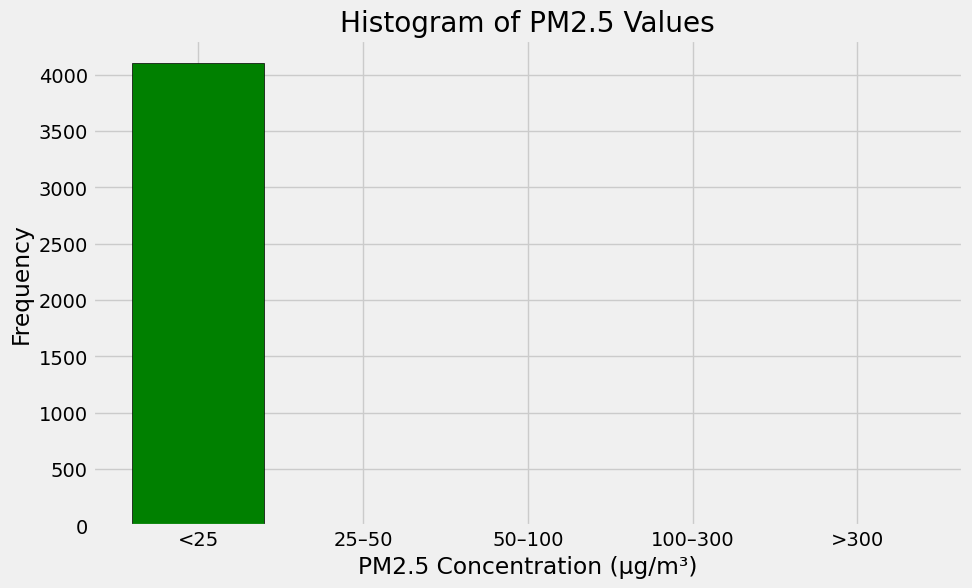

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
from sklearn.neighbors import NearestNeighbors

# Extract the latitude, longitude, and pm25 values
coords = pmdata[['latitude', 'longitude']].values
pm25_values = pmdata['pm25'].values

# Convert latitude and longitude to radians for haversine distance
coords_rad = np.radians(coords)

# Using OPTICS with the 'ball_tree' algorithm and haversine metric for geographical data
clustering = OPTICS(metric='haversine', algorithm='ball_tree', cluster_method='xi')
clustering.fit(coords_rad)

# Define the bins based on the provided categories
bins = [0, 25, 50, 100, 300, np.inf]
bin_labels = ['<25', '25–50', '50–100', '100–300', '>300']

# Create a histogram
hist, edges = np.histogram(pm25_values, bins=bins)

# Plotting the histogram with the same color scheme as in the provided chart
colors = ['green', 'yellow', 'orange', 'red', 'purple']
plt.figure(figsize=(10, 6))
plt.bar(bin_labels, hist, color=colors, edgecolor='black')

# Adding labels and title
plt.xlabel('PM2.5 Concentration (µg/m³)')
plt.ylabel('Frequency')
plt.title('Histogram of PM2.5 Values')

# Show the plot
plt.show()

<font color='Red' size=12> Modified code </font>: April 10, 2024

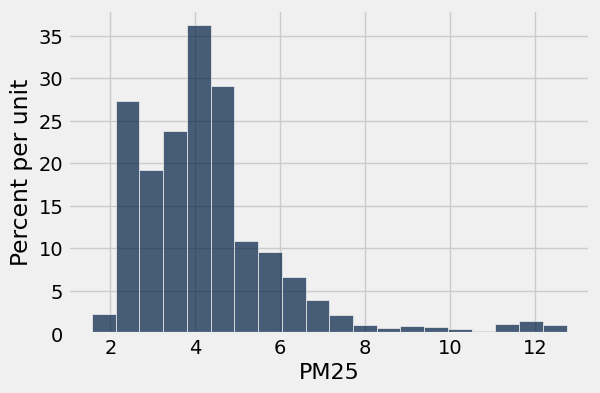

In [ ]:
import matplotlib.pyplot as plt
import datascience as ds
import numpy as np

# Enable inline plotting
%matplotlib inline

# Create a Table with a column of PM10 values
table_selected = ds.tables.Table().with_column('PM25', df['pm25'])

# Draw histogram of PM10 values with specified bins
table_selected.hist(bins=20)
plt.xlabel("PM25")
plt.ylabel("Percent per unit")
plt.show()

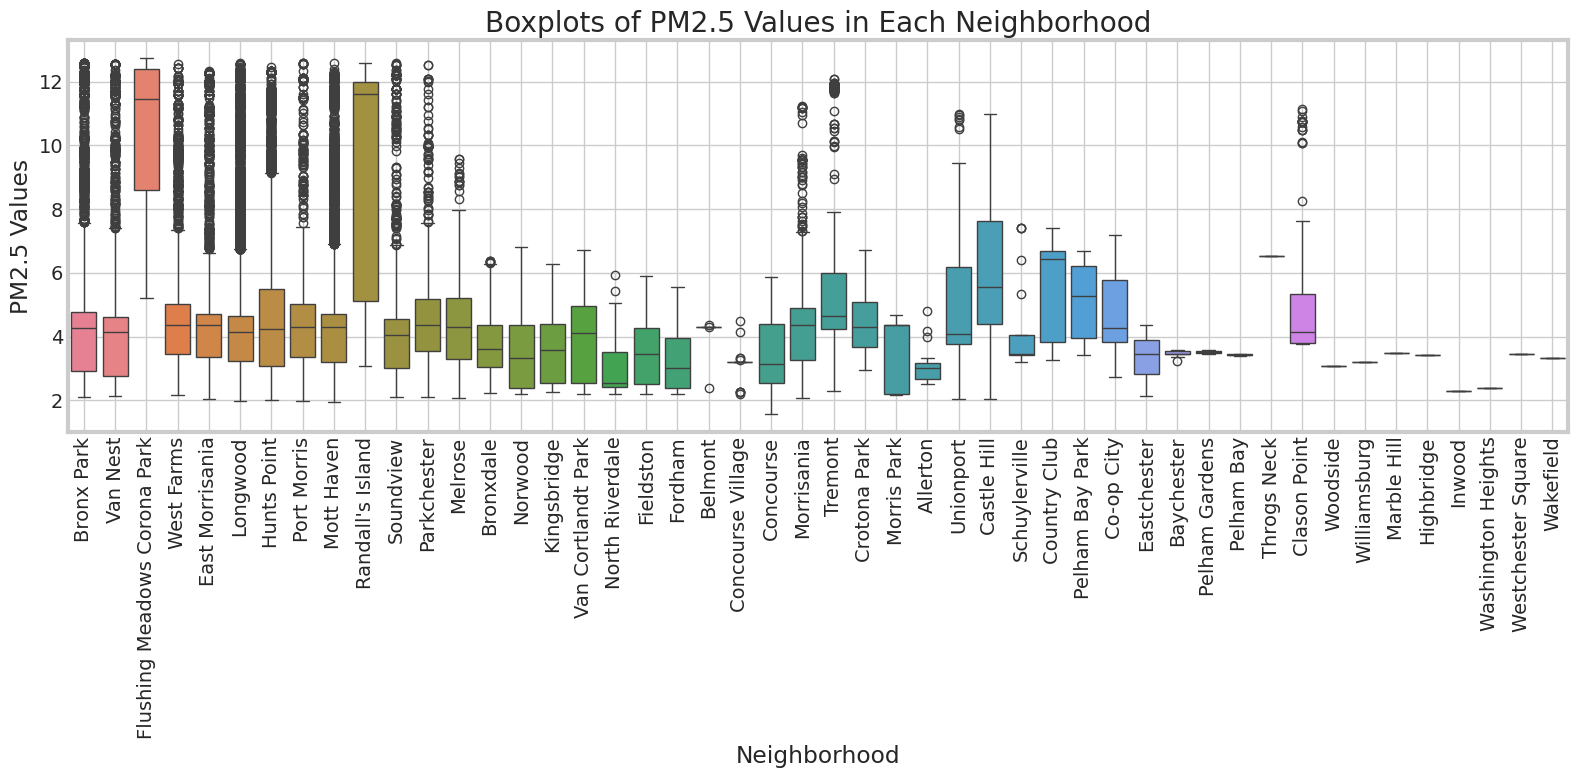

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plots
sns.set_style("whitegrid")

# Plot boxplots for PM2.5 values in each neighborhood
plt.figure(figsize=(16, 8))  # Set a wider figure size

sns.boxplot(data=df, x='neighborhood', y='pm25', hue='neighborhood')

# Add labels and title
plt.xlabel('Neighborhood')
plt.ylabel('PM2.5 Values')
plt.title('Boxplots of PM2.5 Values in Each Neighborhood')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


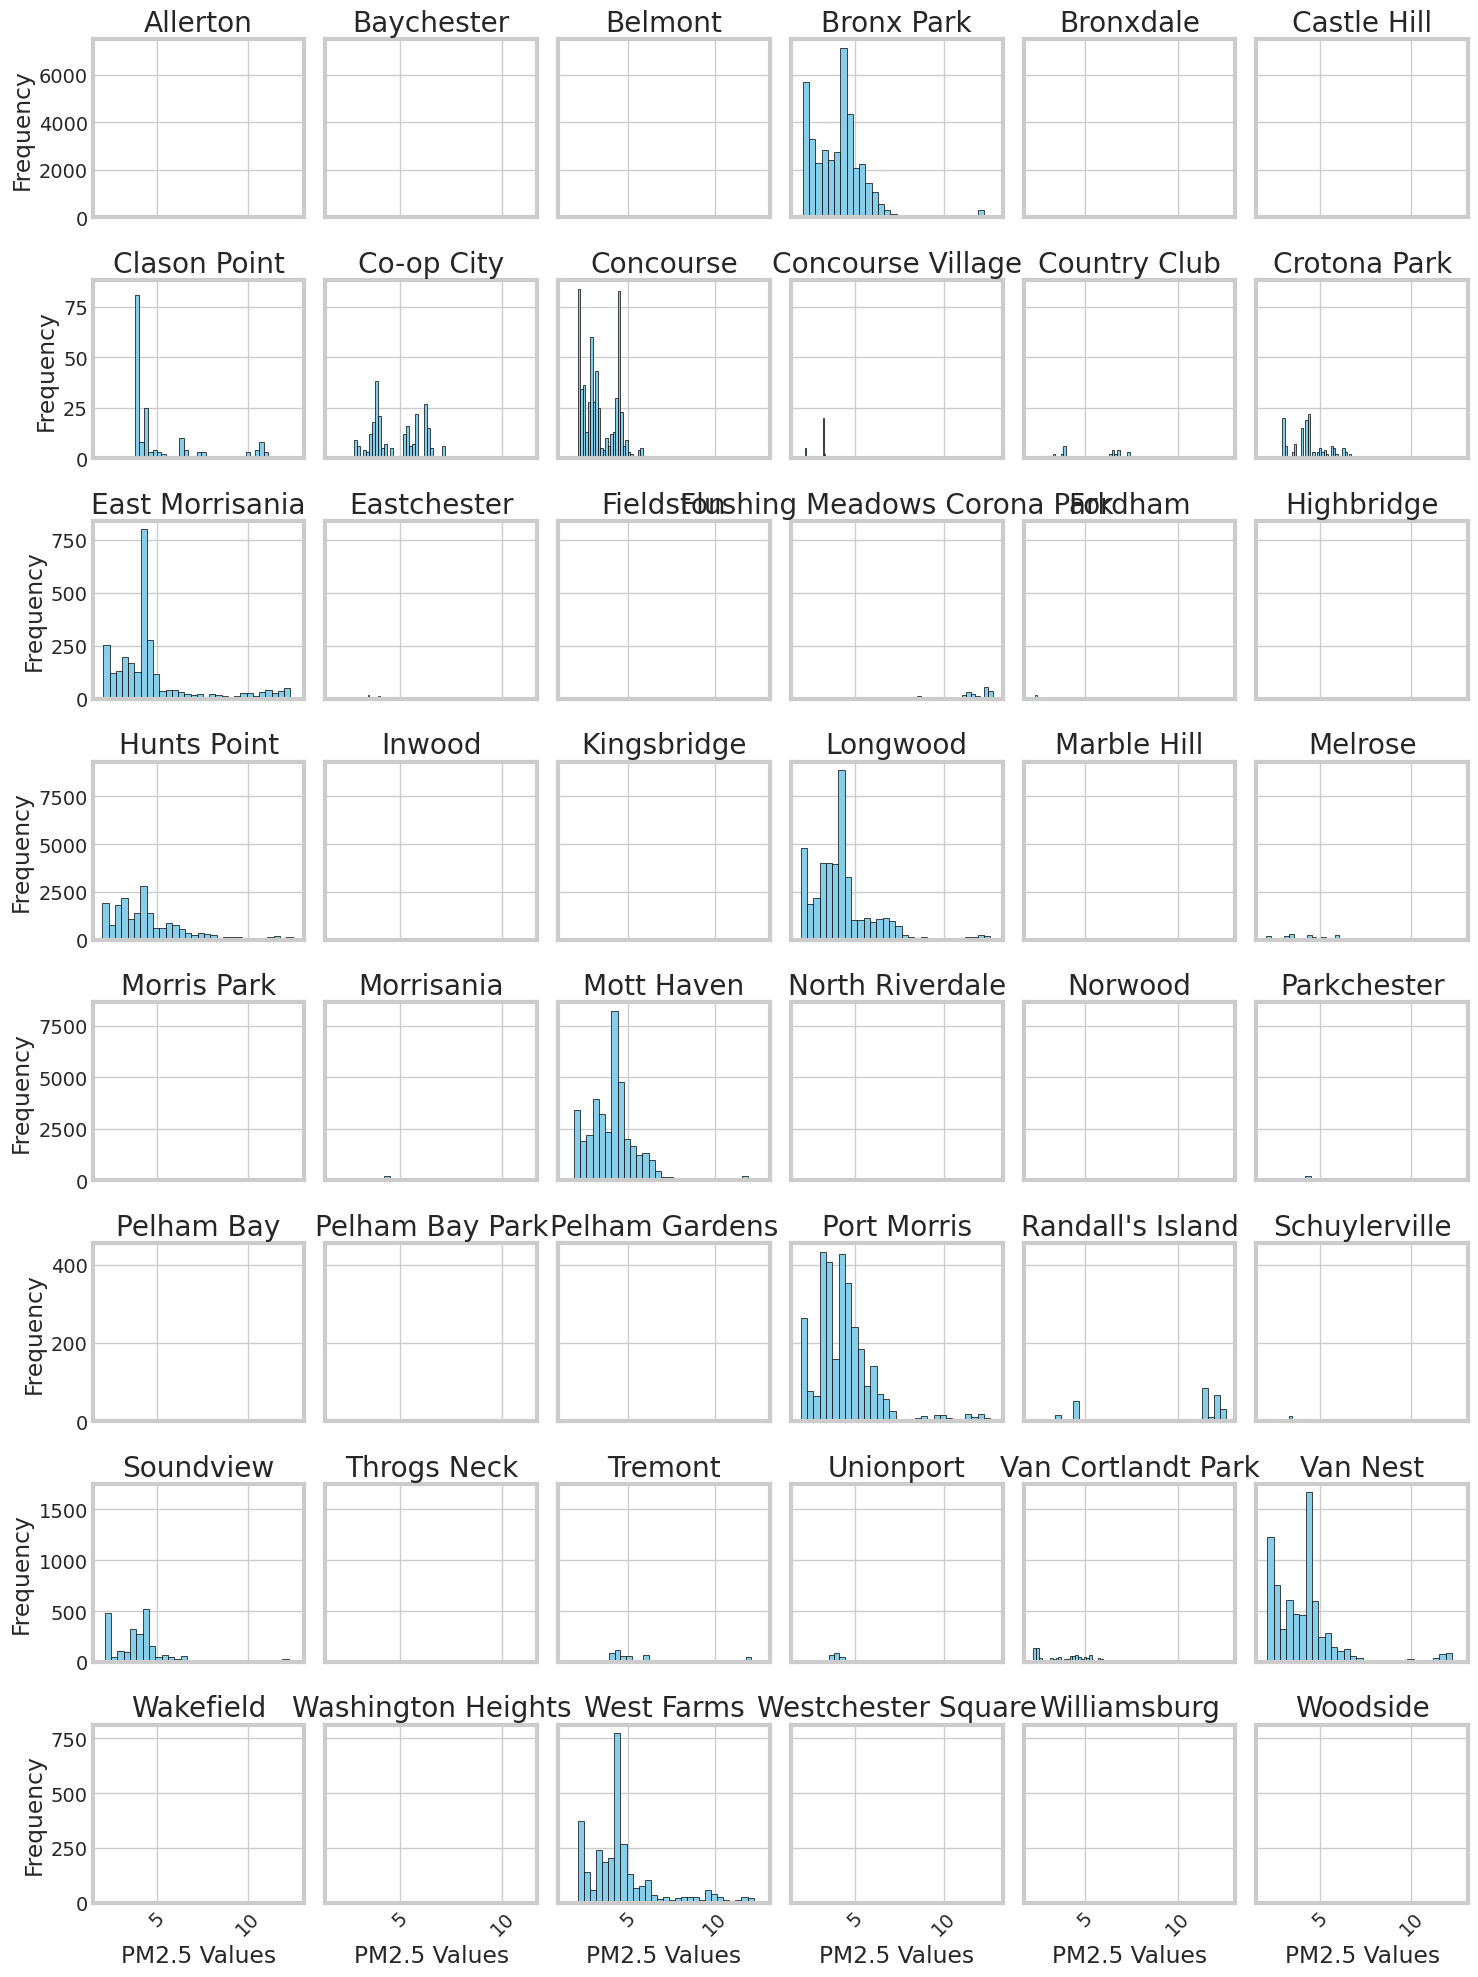

In [ ]:
import datascience as ds

# Assuming your data is stored in the table "table_selected"
# You might need to adjust this code according to the properties of your data and the libraries you're using

# Get unique neighborhood names
neighborhoods = tbl.group('neighborhood').column('neighborhood')

# Calculate the number of rows and columns for subplots
num_neighborhoods = len(neighborhoods)
num_cols = 6 # Number of columns for subplots
num_rows = (num_neighborhoods + num_cols - 1) // num_cols  # Calculate number of rows

# Plot histograms as subplots of two columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20), sharex='col', sharey='row')

# Flatten axs if necessary (if num_neighborhoods is less than num_rows * num_cols)
if isinstance(axs, np.ndarray):
    axs = axs.flatten()
else:
    axs = [axs]

# Plot histograms for each neighborhood
for i, neighborhood in enumerate(neighborhoods):
    # Filter data for the current neighborhood
    neighborhood_data = tbl.where('neighborhood', neighborhood)

    # Plot histogram for PM2.5 values in the current neighborhood
    axs[i].hist(neighborhood_data['pm25'], bins=30, color='skyblue', edgecolor='black')

    # Add title
    axs[i].set_title(f'{neighborhood}')

    # Rotate x-axis labels for better readability
    axs[i].tick_params(axis='x', rotation=45)

# Add shared x-axis labels for each column
for ax in axs[-num_cols:]:
    ax.set_xlabel('PM2.5 Values')

# Add shared y-axis label for each row
for ax in axs[::num_cols]:
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.grid(True)
plt.show()


<font color='blue' size=12> Cont. Supervisor comments </font>: April 2, 2024
- TODO:
  - Also, draw histograms showing the same binning and density of pm2.5 values in each neighborhood in your data. By the way, how many neighborhoods you have in your data?!
  > this is important as it will inform us about the fact wether nearby locations are having similar pm25 values. Why do we need to do this, because it is only in that case we consider those as a cluster, since they are geographiclly nearby, and also having simialr feature values (pm25 in this case). So what you need to do next is the following:
  - .. ```Extract and normalize several features```, similar to what has been done in the following tutorial, read specifically [Extending DBSCAN beyond just spatial coordinates](https://musa-550-fall-2020.github.io/slides/lecture-11A.html), thereafter ```Run DBSCAN to extract high-density clusters``` passing as an argument to the DBSCAN the new ```scaled features```, probably something like ```cores, labels = dbscan(features, eps=eps, min_samples=min_samples)``` . notice passing features (including pm25, longitude, latitude) instead of simply the coordinates.
  - having done this novel distance calculation (based on geometrical distance and pm25 values distance), calculate again the ```silhouette_score```, and check wether you obtain a higher accuracy (higher silhouette_score values) or not!

  > **N.B.** we are able to do this because of the definition of ```metric``` in DBSCAN which says **metric: The metric to use when calculating distance between instances in** a ```feature array``` so, it  a distance between several features is possible, given a ```feature array```, so put your scaled features in a feature array.

  - one importance configurable parameter in this case is the distance metric.
  > you can use instead
    - most importantly the following : ```From scikit-learn: [‘cityblock’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’].```
    - and probably aome of the following ```From scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘rogerstanimoto’, ‘russellrao’,, ‘sokalmichener’, ‘sokalsneath’, ```

  - then, having permutate this configurable parameter, capture the ```silhouette_score``` and compare, then draw an x-y figure such as the following, (```you can do those graphs in MS excel after capturing the numbers```):

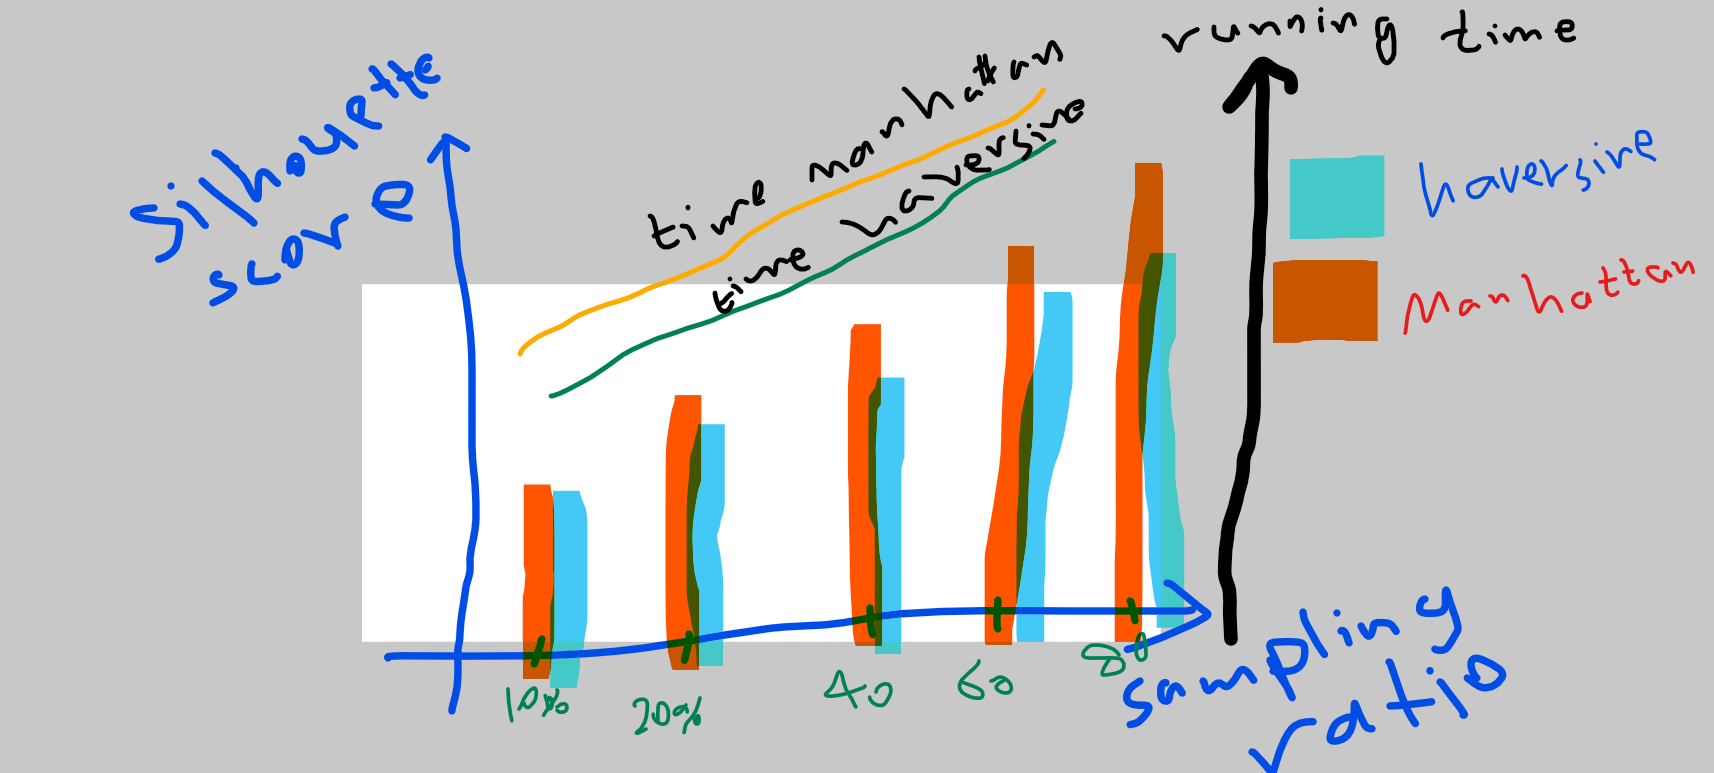

<font color='Green' size=12> Modified code </font>: April 19, 2024

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: di

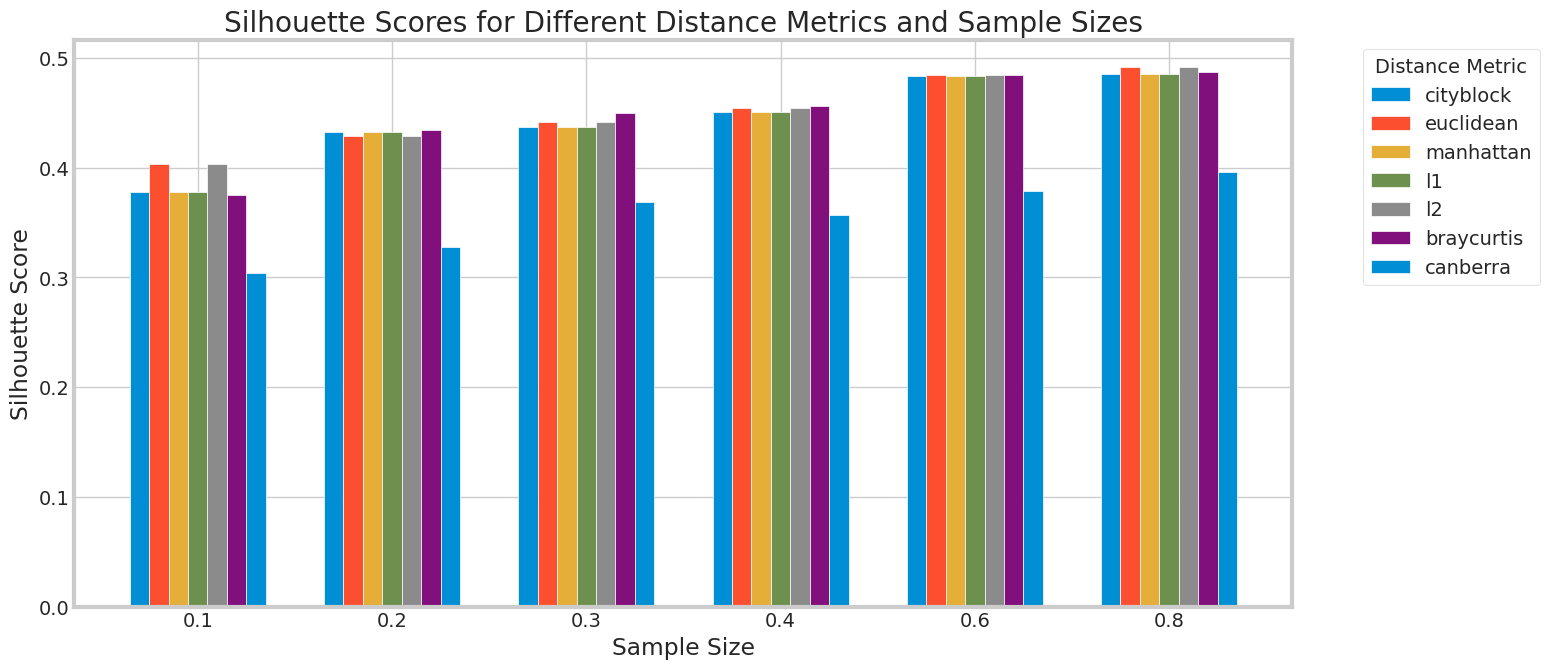

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

features = pmdata[['pm25', 'longitude', 'latitude']]

# Define sample ratios and metrics to test
sample_ratios = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8]
distance_metrics = ['cityblock', 'euclidean', 'manhattan', 'l1', 'l2', 'braycurtis', 'canberra']
silhouette_results = {metric: [] for metric in distance_metrics}

# Iterate over each distance metric
for metric in distance_metrics:
    # Now iterate over each sample ratio
    for ratio in sample_ratios:
        # Sample a fraction of the data based on the ratio
        pmdata_samples = pmdata.sample(frac=ratio, random_state=1)  # ensure reproducibility with random_state
        features_samples = pmdata_samples[['pm25', 'longitude', 'latitude']]

        # Scale the features of the sample
        scaler = StandardScaler()
        features_scaled_sample = scaler.fit_transform(features_samples)

        # Check if we have enough samples to form a cluster
        if len(features_scaled_sample) < 2:
            silhouette_avg = None  # Not enough samples to form a cluster
        else:
            # Run OPTICS on the sampled and scaled features
            optics = OPTICS(min_samples=2, metric=metric)  # minimum sample size is set to 2
            optics.fit(features_scaled_sample)
            labels = optics.labels_

            # Calculate silhouette score only if there are clusters found
            if len(set(labels)) - (1 if -1 in labels else 0) > 1:
                silhouette_avg = silhouette_score(features_scaled_sample, labels)
            else:
                silhouette_avg = None  # No valid clusters found

        silhouette_results[metric].append(silhouette_avg)

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create a bar chart with grouped bars for each sample ratio
bar_width = 0.1
index = np.arange(len(sample_ratios))

for i, (metric, scores) in enumerate(silhouette_results.items()):
  # Offset each metric's bar by the width
  ax.bar(index + i * bar_width, scores, bar_width, label=metric)

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Scores for Different Distance Metrics and Sample Sizes')
ax.set_xticks(index + bar_width * (len(distance_metrics) - 1) / 2)
ax.set_xticklabels(sample_ratios)
ax.legend(title='Distance Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
from sklearn.cluster import OPTICS
import numpy as np

# Assuming 'pmdata' is your DataFrame and it contains 'latitude' and 'longitude' columns.
hotspots = pmdata
coords = hotspots.loc[:, ['latitude', 'longitude']].values

# Preprocessing for hotspot clustering
# Convert to radians, because scikit-learn’s OPTICS (when using haversine) needs radian units
coords_in_radians = np.radians(coords)

# Define the parameters for OPTICS
# xi is the minimum steepness on the reachability plot that constitutes a cluster boundary
# min_samples is the minimum cluster size for a hotspot to be formed
# Here we also call the haversine metric
optics = OPTICS(min_samples=10, xi=0.05, metric='haversine')

# Fit the model
optics.fit(coords_in_radians)

# Extract the labels
cluster_labels = optics.labels_

# Number of clusters, ignoring noise if present
num_clusters = len(set(cluster_labels)) - (1 if -1 in set(cluster_labels) else 0)
n_noise_ = list(cluster_labels).count(-1)

print("Estimated number of clusters: %d" % num_clusters)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 139
Estimated number of noise points: 1615


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [ ]:
#Block 13
#hierarchical clustering code

# bottom-up hierarchical clustering - agglomerative, not k-means, because number of clusters not defined before
hotspots = pmdata
coords = hotspots.loc[:,['latitude','longitude']].values

#preprocessing for hotspot clustering
#we have to convert to radians, because scikit-learn’s haversine metric needs radian units
kms_per_radian = 6371.0088

#epsilon is the max distance points can be from each other to count as a cluster
epsilon = 0.1 / kms_per_radian

#min_samples is the minimum cluster size for a hotspot to be formed, and here we also call the haversine metric
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))-(1 if -1 in set(cluster_labels) else 0)
n_noise_ = list(cluster_labels).count(-1)
#outliers = coords[cluster_labels == -1]

print("Estimated number of clusters: %d" % num_clusters)
print("Estimated number of noise points: %d" % n_noise_)

#here is where we create the clusters after doing the background math above
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
#outliers = coords[cluster_labels == -1]
#print('Number of clusters: {}'.format(num_clusters))
#print('Number of outliers: {}'.format(outliers))



Estimated number of clusters: 32
Estimated number of noise points: 334


<font color='blue' size=12> Supervisor comments </font>: April 2, 2024
- TODO:
 - Provide a detailed explanation of the values you obtained for ```Silhouette Coefficient```
    - take some insights from [scikit-learn docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)
    - That is to say, >
    > "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar."

In [ ]:
from sklearn.cluster import OPTICS
from sklearn import metrics
from sklearn.metrics import silhouette_samples
import numpy as np

# Assuming 'pmdata' is your DataFrame and it contains 'latitude' and 'longitude' columns.
hotspots = pmdata
coords = hotspots.loc[:, ['latitude', 'longitude']].values

# Convert coordinates to radians for haversine metric
coords_in_radians = np.radians(coords)

# Initialize and fit the OPTICS clustering algorithm
optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05, metric='manhattan')
optics.fit(coords_in_radians)

# Extract the labels
cluster_labels = optics.labels_

print(f"Silhouette Coefficient: {metrics.silhouette_score(coords, cluster_labels):.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette Coefficient: -0.270


In [ ]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import DBSCAN

print(f"Silhouette Coefficient: {metrics.silhouette_score(coords, cluster_labels):.3f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd

# Assuming 'pmdata' contains your data

# bottom-up hierarchical clustering - agglomerative, not k-means, because number of clusters not defined before
hotspots = pmdata
coords = hotspots.loc[:,['latitude','longitude']].values

# preprocessing for hotspot clustering
# we have to convert to radians, because scikit-learn’s haversine metric needs radian units
kms_per_radian = 6371.0088

# epsilon is the max distance points can be from each other to count as a cluster
epsilon = 0.1 / kms_per_radian

# min_samples is the minimum cluster size for a hotspot to be formed, and here we also call the haversine metric
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels)) - (1 if -1 in set(cluster_labels) else 0)
n_noise_ = list(cluster_labels).count(-1)
outliers = coords[cluster_labels == -1]

print("Estimated number of clusters: %d" % num_clusters)
print("Estimated number of noise points: %d" % n_noise_)

# Plotting clusters
plt.figure(figsize=(10, 8))

# Generating colors for clusters
colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))

for cluster_label, color in zip(range(num_clusters), colors):
    cluster_mask = (cluster_labels == cluster_label)
    cluster_points = coords[cluster_mask]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], s=20, c=[color], label=f'Cluster {cluster_label}')

# Plotting outliers
plt.scatter(outliers[:, 1], outliers[:, 0], s=20, c='black', label='Outliers')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering of Hotspots')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import folium
import numpy as np
import matplotlib.colors as mcolors

import pandas as pd
from sklearn.cluster import DBSCAN

# Assuming you already have 'cluster_labels' and 'coords' from your code

# Calculate the center of the map
center_lat = np.mean(coords[:, 0])
center_lon = np.mean(coords[:, 1])

# Create the map
map_clusters = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Custom color palette for clusters
colors = plt.cm.tab20.colors[:32]

# Convert colors to hexadecimal format
custom_colors = [mcolors.rgb2hex(color) for color in colors]
# You can add more colors as needed

# Assign colors to clusters
cluster_color_map = {}
for label in set(cluster_labels):
    if label == -1:
        cluster_color_map[label] = 'gray'  # Noise points
    else:
        cluster_color_map[label] = custom_colors[label % len(custom_colors)]

# Plot each data point
for point, cluster_label in zip(coords, cluster_labels):
    folium.CircleMarker(
        location=[point[0], point[1]],
        radius=5,
        color=cluster_color_map[cluster_label],
        fill=True,
        fill_color=cluster_color_map[cluster_label],
        fill_opacity=0.7,
        markeredgecolor="k",
        markersize=6,
    ).add_to(map_clusters)

# Display the map
map_clusters.save("cluster_map.html")  # Save as HTML
map_clusters


<font color='blue' size=12> Cont. Supervisor comments </font>: April 2, 2024
- TODO:
  - you need to do more analytics and Exploratory Spatio-Temporal Data Analytics (ESTDA,  read specifically [Extending DBSCAN beyond just spatial coordinates](https://musa-550-fall-2020.github.io/slides/lecture-11A.html), thereafter, for example ```Identify the 5 largest clusters``` , ```Get mean statistics for the top 5 largest clusters```, ```Visualize the top 5 largest clusters```, ```Visualizing one cluster at a time```.

<font color='Green' size=12> Modified code </font>: April 19, 2024

In [27]:
from sklearn.cluster import OPTICS
import pandas as pd

# Assuming your DataFrame is named `pmdata` and you've already done any necessary preprocessing and scaling
# Replace `scaled_features` with the relevant columns from `pmdata` that you want to use for clustering
optics_model = OPTICS(min_samples=50)

# Fit the model
optics_model.fit(pmdata[['latitude', 'longitude']])  # Include other features as needed

# Extract the labels
pmdata['label'] = optics_model.labels_

# Calculate the number of clusters (ignoring noise)
num_clusters = len(set(pmdata['label'])) - (1 if -1 in pmdata['label'] else 0)
print(f"Number of clusters found: {num_clusters}")

Number of clusters found: 24


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [28]:
#Identify the 5 largest clusters
# Get cluster sizes, from largest to smallest
cluster_sizes = pmdata[pmdata['label'] != -1].groupby('label').size().sort_values(ascending=False)
print(cluster_sizes)

# Extract labels for the top 5 clusters
top5_labels = cluster_sizes.iloc[:5].index
print(f"Top 5 largest cluster labels: {top5_labels.tolist()}")

label
0     201
22    191
21    175
13    138
7     127
16    120
14    117
2     108
6     104
20     99
15     97
12     92
11     91
8      88
5      80
10     76
1      63
4      61
9      60
18     57
3      55
19     53
17     52
dtype: int64
Top 5 largest cluster labels: [0, 22, 21, 13, 7]


In [35]:
# Get mean statistics for the top 5 largest clusters
# Select the rows belonging to the top 5 clusters
top5_data = pmdata[pmdata['label'].isin(top5_labels)]
# Select only numeric columns for mean calculation, excluding 'label' which is not a feature
numeric_columns = pmdata.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_columns.remove('label')  # Assuming 'label' is included in the numeric columns

# Now group by 'label' and calculate the mean only for numeric columns
mean_stats = top5_data.groupby('label')[numeric_columns].mean()

# Display the mean statistics for the top 5 clusters
print(mean_stats)

        latitude  longitude       bin0       bin1       bin2      bin3  \
label                                                                    
0      40.745406 -73.844895  80.820896  13.766169   6.651741  2.477612   
7      40.813159 -73.889654  67.606299  33.173228  23.220472  9.102362   
13     40.813724 -73.913467  61.956522  22.789855  11.978261  3.963768   
21     40.814387 -73.924791  59.531429  24.525714  12.325714  4.040000   
22     40.798672 -73.923172  62.534031  27.298429  14.801047  4.942408   

            bin4       bin5      bin6      bin7  ...  bin17  bin18  bin19  \
label                                            ...                        
0       4.905473   3.726368  1.482587  0.472637  ...    0.0    0.0    0.0   
7      13.370079  10.551181  4.023622  1.055118  ...    0.0    0.0    0.0   
13      6.514493   5.326087  1.840580  0.702899  ...    0.0    0.0    0.0   
21      7.200000   5.228571  1.994286  0.680000  ...    0.0    0.0    0.0   
22      9.073298   

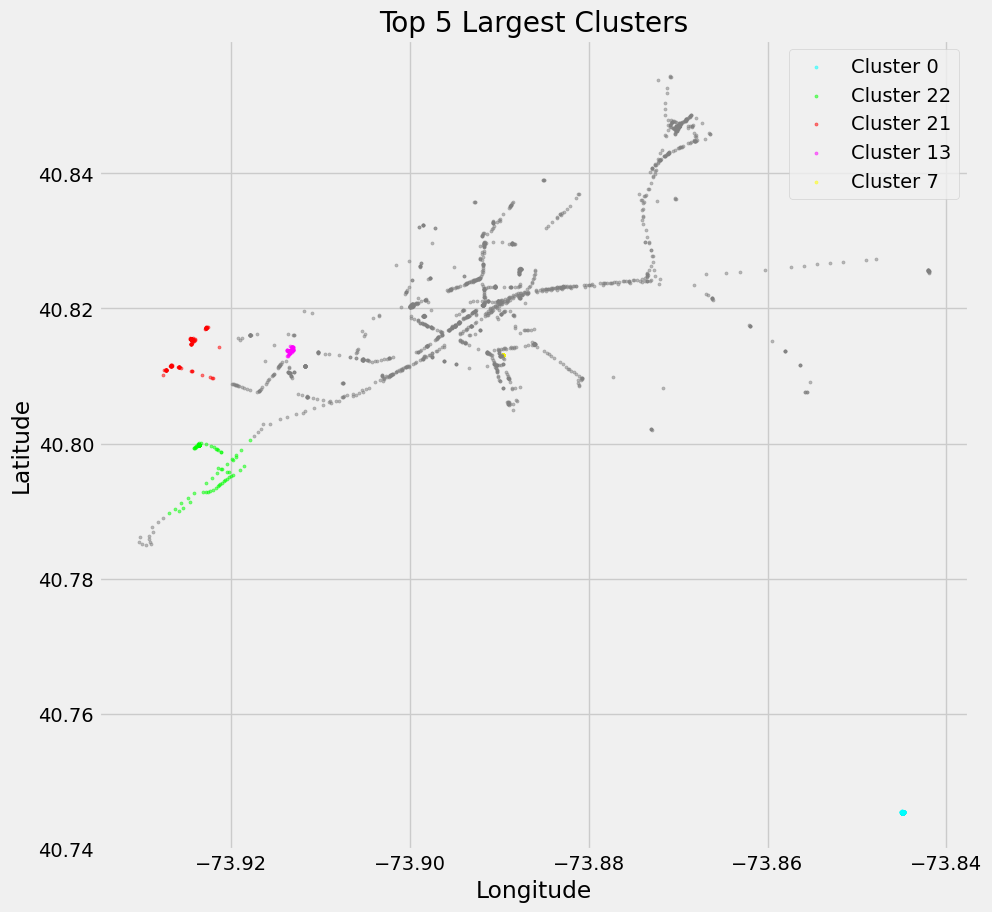

In [36]:
#Visualize the top 5 largest clusters
import matplotlib.pyplot as plt

# Setup figure
plt.figure(figsize=(10, 10))

# Define colors for each cluster
colors = ['aqua', 'lime', 'red', 'fuchsia', 'yellow']

# Plot each of the top 5 clusters with a different color
for i, label_num in enumerate(top5_labels):
    cluster_data = pmdata[pmdata['label'] == label_num]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], c=colors[i], label=f'Cluster {label_num}', s=5, alpha=0.5)

# Plot noise in grey
noise_data = pmdata[pmdata['label'] == -1]
plt.scatter(noise_data['longitude'], noise_data['latitude'], c='grey', s=5, alpha=0.5)

# Legend and titles
plt.legend()
plt.title('Top 5 Largest Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<font color='blue' size=12> Cont. Supervisor comments </font>: April 2, 2024
- TODO
  - add other metrics from the [sklearn.metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation), for example the following:
  > - ```Davies-Bouldin Index```, **Zero is the lowest possible score. Values closer to zero indicate a better partition.**
  for your experiment, we have obtained a number on par with 2.78!, which is very high! so probably your clustering scheme misses something! try different combinations of configurations (sampling scheme, distance methods, distance based on combination of features such as geographical long/lat and pm25 values), read my previous comments to get insights.
    - ```Calinski-Harabasz Index```. You have computed that already, but what is your explanation and reasoning of the results obtained!

In [ ]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(np.radians(coords), cluster_labels)

##Resources and references


Papers:
*   [Challenges of Drive-By IoT Sensing for Smart Cities: City Scanner Case Study](https://senseable.mit.edu/papers/pdf/20181012_Anjomshooa-etal_ChallengesDrive-by_Purba.pdf)
*  [ City Scanner: Building and Scheduling a Mobile
Sensing Platform for Smart City Services](https://senseable.mit.edu/papers/pdf/20180522_Anjomshoaa-etal_CityScanner_IEEE-IoT.pdf)
* [Air quality monitoring using mobile low-cost sensors mounted on trashtrucks: Methods development and lessons learned](https://senseable.mit.edu/papers/pdf/20200601_deSouza-etal_AirQuality_SCS.pdf)



Python Library Documentation:
*  [Folium](http://python-visualization.github.io/folium/)
*  [Pandas](https://pandas.pydata.org/)
* [Matplotlib](https://matplotlib.org/)


